In [1]:
# grid search over hyperparams

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate
import torch
import os
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import gc

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

lrs = [1e-5, 5e-5, 1e-4, 5e-4]
batch_sizes = [8, 16, 32, 64]
max_epochs = 3

data = {}

model_name = 'EleutherAI/pythia-70m'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

path = '../../../gld/train-data-probes/data/llama-2-7b'
dataset = load_from_disk(os.path.join(path, 'pythia_llama_mem_dataset_split'))

id2label = {0: 'neg', 1: 'pos'}
label2id = {'neg': 0, 'pos': 1}

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
def tpr_at_fpr(probs, labels, target_fpr, left=0.5, right=1.0, max_steps=1000, thresh_tol=1e-5): 
    """
    Calculates the true positive rate at a given false positive rate. 
    Does up to max_steps steps of binary search, returns the best guess 
    that yields a false positive rate less than target_fpr
    
    probs: (n_examples, ) just prob on positive class
    labels: (n_examples, ) 0 or 1
    """
    assert len(probs) == len(labels)
    assert probs.shape == labels.shape
    assert probs.shape[0] > 0

    for _ in range(max_steps):
        mid = (left + right) / 2
        
        # calc fpr 
        preds = (probs > mid).astype(int)
        fp = np.logical_and(preds == 1, labels == 0).sum()
        tn = (labels == 0).sum()
        fpr = fp / tn if tn > 0 else 0

        if abs(fpr - target_fpr) < thresh_tol: 
            right = mid
            break
        elif fpr > target_fpr:
            left = mid
        else:
            right = mid
    
    # use right as threshold to ensure fpr <= target_fpr
    preds = (probs > right).astype(int)
    tp = np.logical_and(preds == 1, labels == 1).sum()
    fn = (labels == 1).sum()
    return tp / fn if fn > 0 else 0
    

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'index_in_final_states', 'index_in_og_states', 'ground_str', 'ground_llama_toks'],
        num_rows: 4800
    })
    val: Dataset({
        features: ['label', 'index_in_final_states', 'index_in_og_states', 'ground_str', 'ground_llama_toks'],
        num_rows: 800
    })
    test: Dataset({
        features: ['label', 'index_in_final_states', 'index_in_og_states', 'ground_str', 'ground_llama_toks'],
        num_rows: 2400
    })
})

In [4]:
# tokenize datasets


def tokenize(example): 
    return {'input_ids': tokenizer(example['ground_str'], padding='max_length', truncation=True)['input_ids']}

dataset['train'] = dataset['train'].map(tokenize, batched=False)
dataset['val'] = dataset['val'].map(tokenize, batched=False)
dataset['test'] = dataset['test'].map(tokenize, batched=False)

max_train_len = max([len(x) for x in dataset['train']['input_ids']])
max_val_len = max([len(x) for x in dataset['val']['input_ids']])
max_test_len = max([len(x) for x in dataset['test']['input_ids']])  

def pad(example): 
    curr_len = len(example['input_ids'])
    pad_len = max_train_len - curr_len
    return {'input_ids': example['input_ids'] + [tokenizer.pad_token_id] * pad_len}

dataset['train'] = dataset['train'].map(pad, batched=False)
dataset['val'] = dataset['val'].map(pad, batched=False)
dataset['test'] = dataset['test'].map(pad, batched=False)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map:  92%|█████████▎| 740/800 [00:00<00:00, 3685.66 examples/s]

Map: 100%|██████████| 800/800 [00:00<00:00, 9168.40 examples/s]


In [5]:
train_lens = [len(x['input_ids']) for x in dataset['train']]
val_lens = [len(x['input_ids']) for x in dataset['val']]
test_lens = [len(x['input_ids']) for x in dataset['test']]

assert len(set(train_lens)) == len(set(val_lens)) == len(set(test_lens)) == 1, (set(train_lens), set(val_lens), set(test_lens))

In [6]:
pbar = tqdm(total=len(lrs)*len(batch_sizes))

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)
        model.to('cuda')
        model.config.pad_token_id = model.config.eos_token_id

        targs = TrainingArguments(
            output_dir = os.path.join(path, 'finetuning/'),
            evaluation_strategy = 'epoch',
            logging_strategy = 'epoch',
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=128,
            num_train_epochs=max_epochs,
            weight_decay=0.01,
            report_to='none',
        )

        data[f'lr_{lr}_batch_size_{batch_size}'] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'AUC': [], 'tpr_01': [], 'tpr_001': [], 'tpr_0001': []}
        
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            logits = np.array(logits[0]) # (n_examples, n_classes)
            labels = np.array(labels) # (n_examples)

            preds = np.argmax(logits, axis=1)
            normalized_prob = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
            positive_prob = normalized_prob[:, 1]
            acc = accuracy_score(labels, preds)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
            auc = roc_auc_score(labels, positive_prob)
            
            # calculate tpr at fpr = 0.01, 0.001, and 0.0001
            tpr_01 = tpr_at_fpr(positive_prob, labels, 0.01)
            tpr_001 = tpr_at_fpr(positive_prob, labels, 0.001)
            tpr_0001 = tpr_at_fpr(positive_prob, labels, 0.0001)

            # log
            data[f'lr_{lr}_batch_size_{batch_size}']['accuracy'].append(acc)
            data[f'lr_{lr}_batch_size_{batch_size}']['precision'].append(precision)
            data[f'lr_{lr}_batch_size_{batch_size}']['recall'].append(recall)
            data[f'lr_{lr}_batch_size_{batch_size}']['f1'].append(f1)
            data[f'lr_{lr}_batch_size_{batch_size}']['AUC'].append(auc)
            data[f'lr_{lr}_batch_size_{batch_size}']['tpr_01'].append(tpr_01)
            data[f'lr_{lr}_batch_size_{batch_size}']['tpr_001'].append(tpr_001)
            data[f'lr_{lr}_batch_size_{batch_size}']['tpr_0001'].append(tpr_0001)

            return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'AUC': auc, 'tpr_01': tpr_01, 'tpr_001': tpr_001, 'tpr_0001': tpr_0001}
        
        trainer = Trainer(
            model=model,
            args=targs,
            train_dataset=dataset['train'],
            eval_dataset=dataset['val'], 
            compute_metrics=compute_metrics,
        )

        trainer.train()
        pbar.update(1)

        del model
        del trainer

        torch.cuda.empty_cache()
        gc.collect()

  0%|          | 0/16 [00:00<?, ?it/s]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (0), or the `sep_token_id` (None), and your input is not padded.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.622100,0.408331,0.813750,0.833333,0.799031,0.815822,0.895189,0.416465,0.121065,0.121065
2,0.265600,0.397549,0.835000,0.852130,0.823245,0.837438,0.909386,0.435835,0.111380,0.111380
3,0.139300,0.416462,0.837500,0.871391,0.803874,0.836272,0.913659,0.450363,0.092010,0.092010


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  6%|▋         | 1/16 [01:11<17:58, 71.90s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.852600,0.433873,0.788750,0.816062,0.762712,0.788486,0.881644,0.271186,0.125908,0.125908
2,0.325800,0.379563,0.820000,0.854881,0.784504,0.818182,0.910105,0.428571,0.266344,0.266344
3,0.213300,0.371318,0.837500,0.865633,0.811138,0.837500,0.916318,0.430993,0.273608,0.273608


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 12%|█▎        | 2/16 [01:52<12:30, 53.60s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.088700,0.488229,0.757500,0.774436,0.748184,0.761084,0.845687,0.324455,0.084746,0.084746
2,0.399400,0.429974,0.793750,0.824607,0.762712,0.792453,0.882588,0.292978,0.123487,0.123487
3,0.298500,0.412818,0.803750,0.842246,0.762712,0.800508,0.893331,0.312349,0.135593,0.135593


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 19%|█▉        | 3/16 [02:20<09:01, 41.68s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.534300,0.652705,0.677500,0.705570,0.644068,0.673418,0.738105,0.089588,0.058111,0.058111
2,0.514400,0.503703,0.760000,0.782609,0.740920,0.761194,0.835739,0.234867,0.062954,0.062954
3,0.393800,0.477579,0.772500,0.800000,0.745763,0.771930,0.854509,0.237288,0.070218,0.070218


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 25%|██▌       | 4/16 [02:41<06:44, 33.68s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.544900,0.414880,0.822500,0.916923,0.721550,0.807588,0.922018,0.346247,0.033898,0.033898
2,0.261100,0.314975,0.882500,0.877069,0.898305,0.887560,0.947939,0.338983,0.002421,0.002421
3,0.104700,0.410285,0.877500,0.892768,0.866828,0.879607,0.948314,0.484262,0.000000,0.000000


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 31%|███▏      | 5/16 [03:50<08:28, 46.21s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.574300,0.367415,0.837500,0.805616,0.903148,0.851598,0.922468,0.450363,0.225182,0.225182
2,0.245400,0.320643,0.865000,0.882206,0.852300,0.866995,0.940062,0.418886,0.186441,0.186441
3,0.107200,0.358985,0.862500,0.872236,0.859564,0.865854,0.941763,0.450363,0.142857,0.142857


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 38%|███▊      | 6/16 [04:30<07:23, 44.31s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.690100,0.355818,0.826250,0.817130,0.854722,0.835503,0.925634,0.317191,0.171913,0.171913
2,0.272200,0.306605,0.878750,0.876190,0.891041,0.883553,0.942277,0.380145,0.150121,0.150121
3,0.143100,0.309734,0.880000,0.897243,0.866828,0.881773,0.947920,0.416465,0.164649,0.164649


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 44%|████▍     | 7/16 [04:57<05:48, 38.70s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.892100,0.389793,0.837500,0.863753,0.813559,0.837905,0.908009,0.382567,0.193705,0.193705
2,0.301700,0.336790,0.851250,0.876923,0.828087,0.851806,0.930502,0.447942,0.140436,0.140436
3,0.194300,0.324435,0.857500,0.861985,0.861985,0.861985,0.935501,0.474576,0.157385,0.157385


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 50%|█████     | 8/16 [05:19<04:27, 33.42s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.568700,0.383114,0.845000,0.827664,0.883777,0.854801,0.914910,0.351090,0.012107,0.012107
2,0.275200,0.327055,0.871250,0.899485,0.845036,0.871411,0.941770,0.452785,0.000000,0.000000
3,0.105000,0.475527,0.881250,0.895522,0.871671,0.883436,0.951474,0.573850,0.000000,0.000000


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 56%|█████▋    | 9/16 [06:28<05:10, 44.39s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_fu

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.697500,0.404839,0.813750,0.764000,0.924939,0.836802,0.924677,0.387409,0.121065,0.121065
2,0.319300,0.355742,0.841250,0.910920,0.767554,0.833114,0.943159,0.365617,0.021792,0.021792
3,0.152400,0.375535,0.870000,0.868735,0.881356,0.875000,0.946262,0.503632,0.000000,0.000000


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 62%|██████▎   | 10/16 [07:09<04:19, 43.25s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,0.846400,0.388791,0.820000,0.768463,0.932203,0.842451,0.920635,0.326877,0.116223,0.116223
2,0.305700,0.306437,0.861250,0.840090,0.903148,0.870478,0.944835,0.455206,0.048426,0.048426
3,0.165300,0.339867,0.867500,0.880893,0.859564,0.870098,0.941757,0.346247,0.014528,0.014528


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 69%|██████▉   | 11/16 [07:36<03:11, 38.28s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.152500,0.441550,0.763750,0.891608,0.617433,0.729614,0.905782,0.319613,0.222760,0.222760
2,0.405200,0.349571,0.841250,0.842105,0.852300,0.847172,0.924483,0.462470,0.208232,0.208232
3,0.245000,0.326942,0.857500,0.863747,0.859564,0.861650,0.935676,0.384988,0.089588,0.089588


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 75%|███████▌  | 12/16 [07:57<02:12, 33.08s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.381400,0.693817,0.578750,0.550802,0.997579,0.709733,0.877183,0.249395,0.092010,0.092010
2,0.507900,0.662508,0.688750,0.931579,0.428571,0.587065,0.860665,0.305085,0.067797,0.067797
3,0.183300,0.602272,0.800000,0.840970,0.755448,0.795918,0.893412,0.295400,0.038741,0.038741


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 81%|████████▏ | 13/16 [09:05<02:11, 43.80s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,1.877100,0.502944,0.737500,0.907631,0.547215,0.682779,0.885592,0.314770,0.062954,0.062954
2,0.486900,0.765297,0.732500,0.930736,0.520581,0.667702,0.893100,0.343826,0.305085,0.305085
3,0.190300,0.505953,0.806250,0.860335,0.745763,0.798962,0.902197,0.242131,0.111380,0.111380


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 88%|████████▊ | 14/16 [09:46<01:25, 42.81s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,2.229200,0.916099,0.493750,1.000000,0.019370,0.038005,0.782301,0.019370,0.019370,0.019370
2,0.939900,0.947987,0.667500,0.986755,0.360775,0.528369,0.877602,0.360775,0.113801,0.113801
3,0.319800,0.441799,0.811250,0.829146,0.799031,0.813810,0.891679,0.331719,0.072639,0.072639


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 94%|█████████▍| 15/16 [10:13<00:38, 38.09s/it]Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-70m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_f

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc,Tpr 01,Tpr 001,Tpr 0001
1,3.782600,0.804228,0.530000,0.974359,0.092010,0.168142,0.577629,0.092010,0.089588,0.089588
2,0.973000,0.601267,0.606250,0.578778,0.871671,0.695652,0.736885,0.249395,0.162228,0.162228
3,0.537000,0.524777,0.716250,0.698718,0.791768,0.742338,0.824277,0.288136,0.111380,0.111380


/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 16/16 [10:34<00:00, 33.06s/it]

In [7]:
import pickle

with open(os.path.join(path, 'finetuning/grid_search_results.pkl'), 'wb') as f:
    pickle.dump(data, f)

## Plot

In [9]:
import pickle
import os

lrs = [1e-5, 5e-5, 1e-4, 5e-4]
batch_sizes = [8, 16, 32, 64]
max_epochs = 10

path = '../../../gld/train-data-probes/data/12b'
with open(os.path.join(path, 'finetuning/grid_search_results.pkl'), 'rb') as f:
    data = pickle.load(f)

len(data.keys())

20

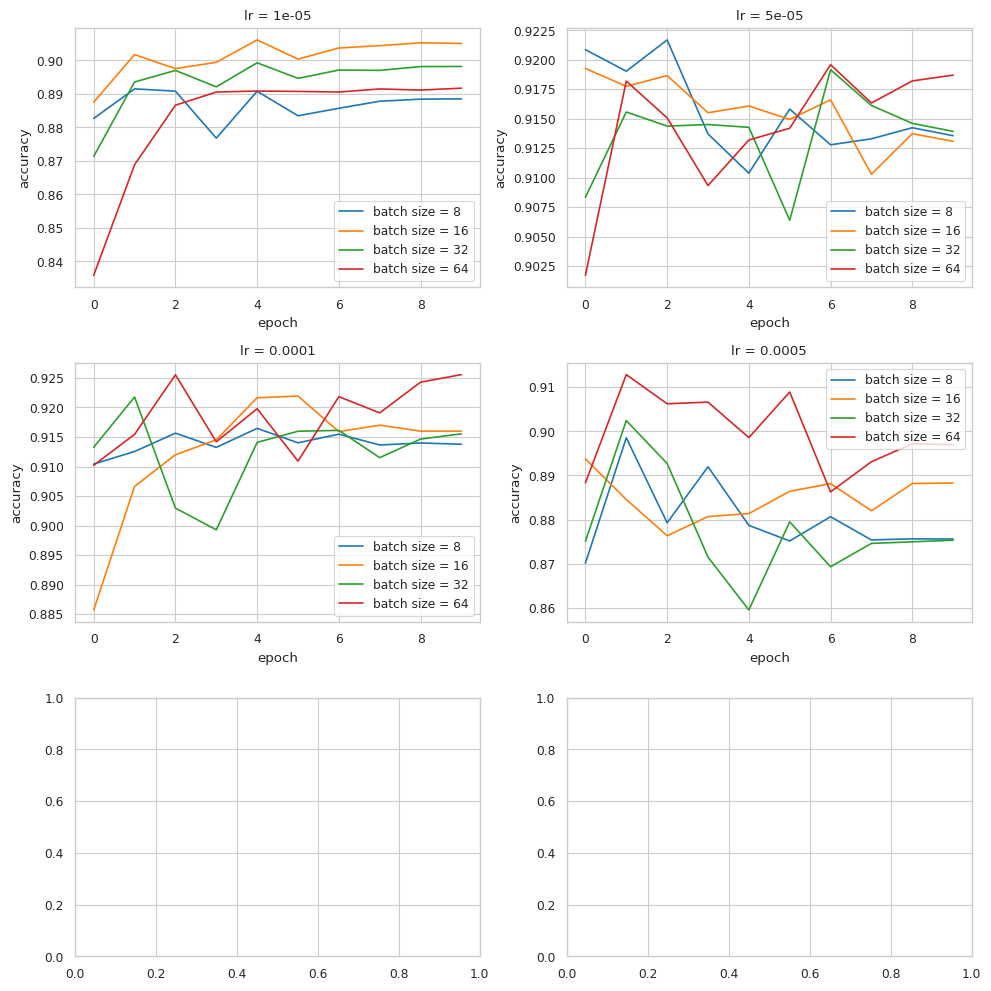

In [10]:
# create a 3 x 2 plot with 5 subplots
# one for each lr

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
sns.set_context('paper')

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, lr in enumerate(lrs):
    for batch_size in batch_sizes:
        acc = data[f'lr_{lr}_batch_size_{batch_size}']['AUC']
        axes[i].plot(range(len(acc)), acc, label=f'batch size = {batch_size}')
        axes[i].set_title(f'lr = {lr}')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel('accuracy')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [11]:
# find epoch with best AUC for each lr and batch size
best_epochs = {}
for lr in lrs:
    for batch_size in batch_sizes:
        acc = data[f'lr_{lr}_batch_size_{batch_size}']['AUC']
        best_epochs[f'lr_{lr}_batch_size_{batch_size}'] = np.argmax(acc)

best_epochs

{'lr_1e-05_batch_size_8': 1,
 'lr_1e-05_batch_size_16': 4,
 'lr_1e-05_batch_size_32': 4,
 'lr_1e-05_batch_size_64': 9,
 'lr_5e-05_batch_size_8': 2,
 'lr_5e-05_batch_size_16': 0,
 'lr_5e-05_batch_size_32': 6,
 'lr_5e-05_batch_size_64': 6,
 'lr_0.0001_batch_size_8': 4,
 'lr_0.0001_batch_size_16': 5,
 'lr_0.0001_batch_size_32': 1,
 'lr_0.0001_batch_size_64': 9,
 'lr_0.0005_batch_size_8': 1,
 'lr_0.0005_batch_size_16': 0,
 'lr_0.0005_batch_size_32': 1,
 'lr_0.0005_batch_size_64': 1}

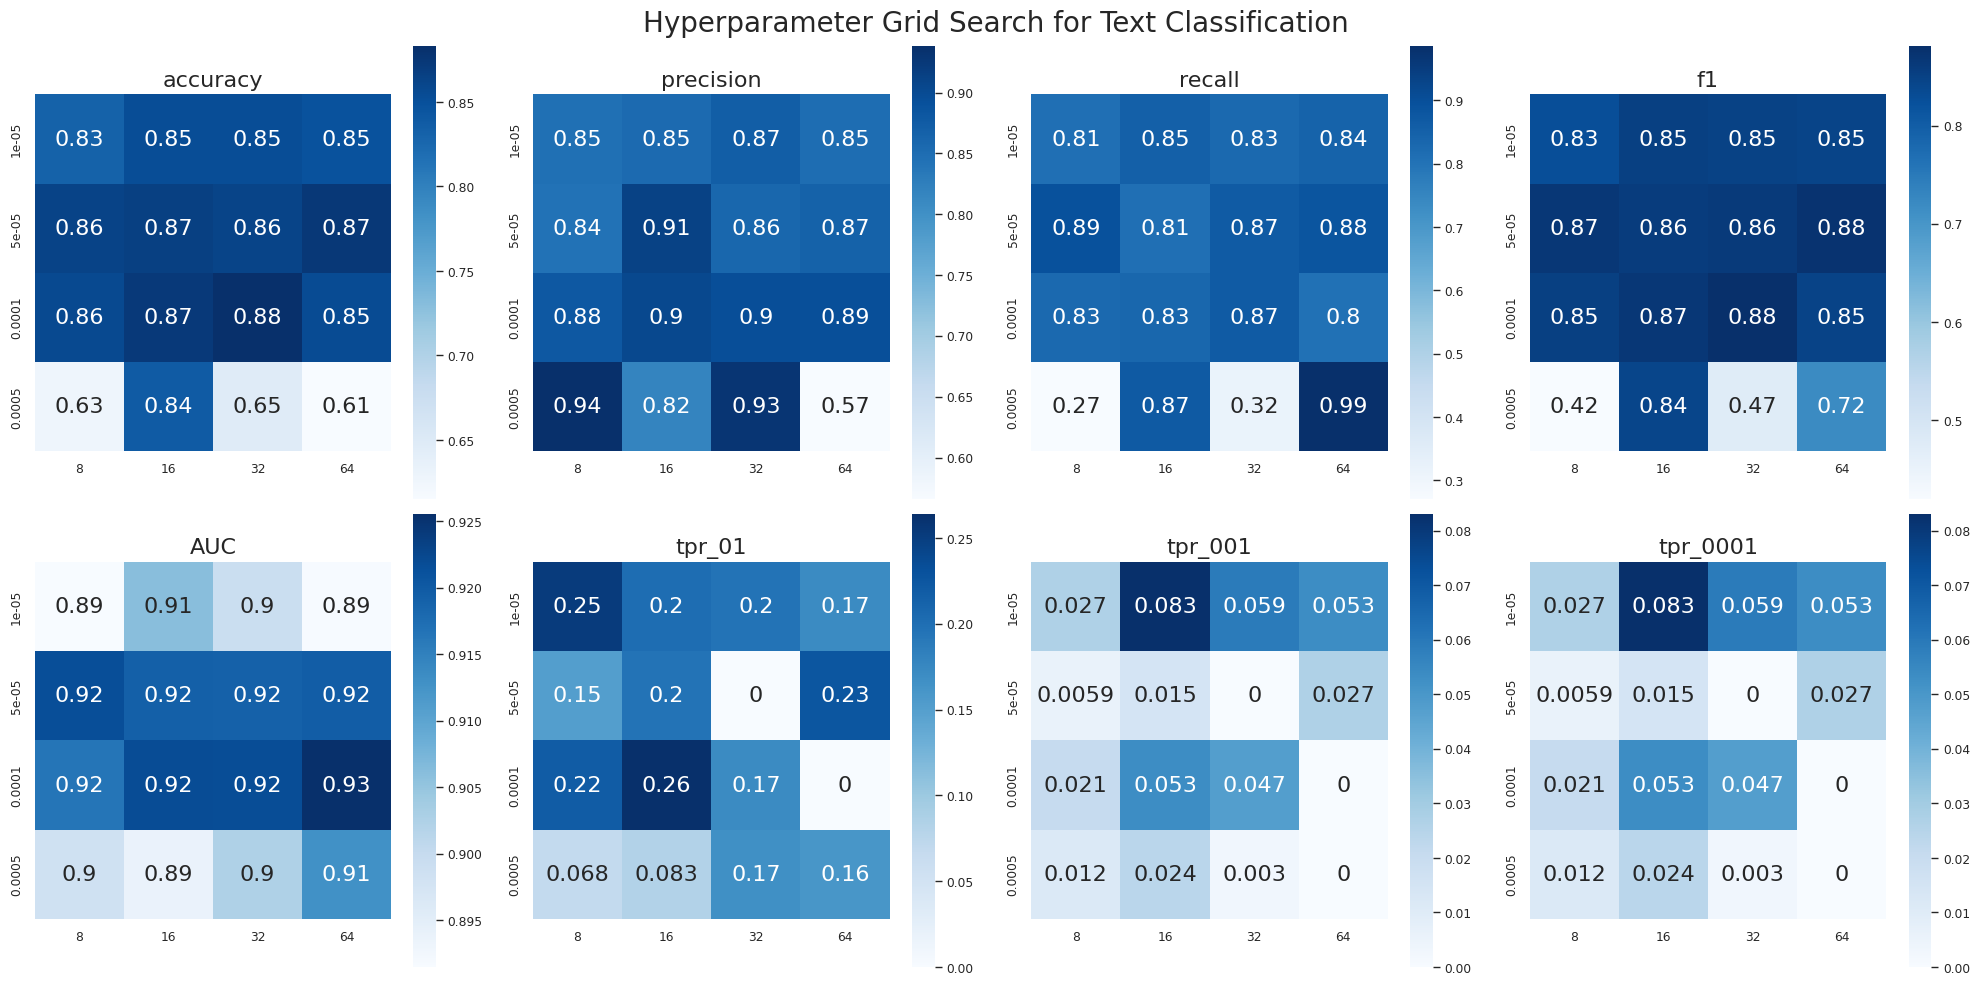

In [12]:
# chopping off the last lr to make square lol 
lrs = [1e-5, 5e-5, 1e-4, 5e-4]

fig, axs = plt.subplots(2,4, figsize=(20,10))
axs = axs.flatten()

for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'AUC', 'tpr_01', 'tpr_001', 'tpr_0001']):
    data_matrix = np.zeros((len(lrs), len(batch_sizes)))
    for j, lr in enumerate(lrs):
        for k, batch_size in enumerate(batch_sizes):
            data_matrix[j,k] = data[f'lr_{lr}_batch_size_{batch_size}'][metric][best_epochs[f'lr_{lr}_batch_size_{batch_size}']]
    sns.heatmap(data_matrix, annot=True, xticklabels=batch_sizes, yticklabels=lrs, ax=axs[i], square=True, cmap='Blues', annot_kws={'fontsize': 16})
    axs[i].set_title(metric, fontsize=16)

plt.suptitle('Hyperparameter Grid Search for Text Classification', fontsize=20)
plt.tight_layout()
plt.show()

# plt.savefig('grid_search.png', dpi=300)